In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as mpl
from IPython.core.pylabtools import figsize

In [2]:
figsize(15, 15)


#  Загрузка данных

In [3]:
df = pd.read_json('./prepared.json')

In [4]:
df.head()

,iso_code,date,new_cases,new_deaths,reproduction_rate,population_density,median_age,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,population,rt
69,1,2020-03-11 21:00:00,3,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,0.0
70,1,2020-03-12 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
71,1,2020-03-13 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
72,1,2020-03-14 21:00:00,0,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,1.0
73,1,2020-03-15 21:00:00,3,0,0.0,54.422,18.6,1803.987,597.029,9.59,0.5,64.83,0.511,41128772,0.5


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 267713 entries, 69 to 318384
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   iso_code                    267713 non-null  int64         
 1   date                        267713 non-null  datetime64[ns]
 2   new_cases                   267713 non-null  int64         
 3   new_deaths                  267713 non-null  int64         
 4   reproduction_rate           267713 non-null  float64       
 5   population_density          267713 non-null  float64       
 6   median_age                  267713 non-null  float64       
 7   gdp_per_capita              267713 non-null  float64       
 8   cardiovasc_death_rate       267713 non-null  float64       
 9   diabetes_prevalence         267713 non-null  float64       
 10  hospital_beds_per_thousand  267713 non-null  float64       
 11  life_expectancy             267713 non-null

Почему то не тот тип данных у даты

In [6]:
df.date = df.date.values.astype(float)

# Кластеризация

Для кластеризации используем модель к-средних, как зарекомендовавшую себя точной работой


In [7]:
from sklearn.cluster import KMeans

По заданию нужно разделить на 3 зоны - 3 клаcтера

In [8]:
kmeans = KMeans(n_clusters=3,  random_state=42)
kmeans.fit(df[['rt']])

c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [9]:
kmeans_df = df.copy()
kmeans_df['labels'] = kmeans.labels_

In [10]:
kmeans_df.labels.value_counts()

labels
0    147258
1    102474
2     17981
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='rt'>

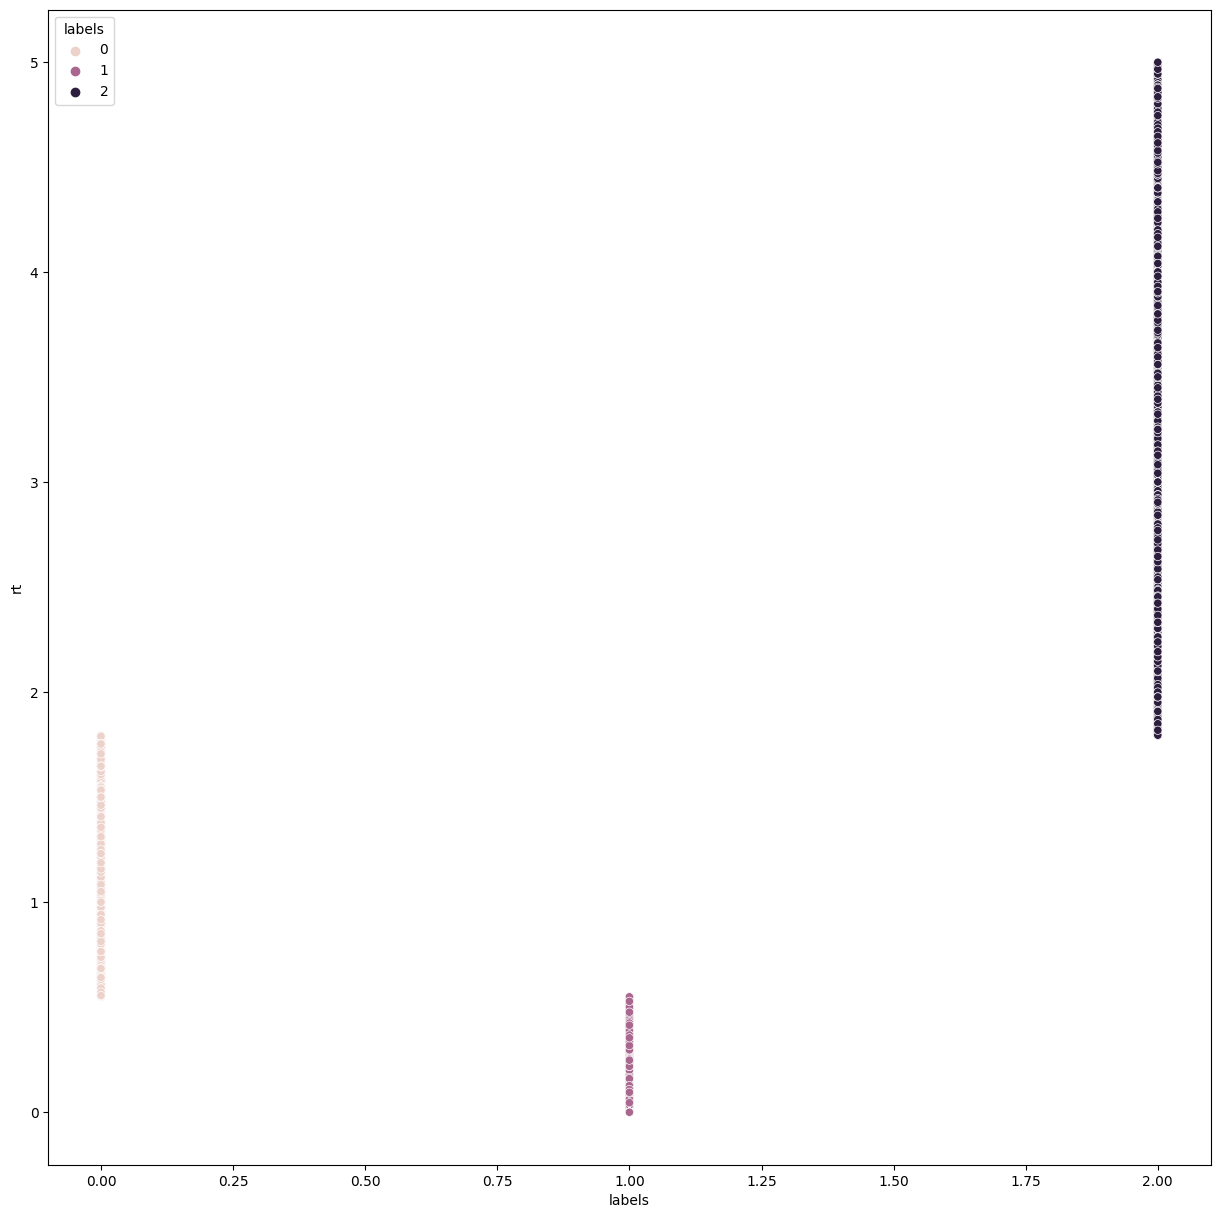

In [52]:
sb.scatterplot(x=kmeans_df.labels, y=kmeans_df.rt, hue=kmeans_df.labels)

Кластеры выглядят неплохо, небольшое наложение есть, но большая часть распределяется хорошо. Получается, что:
- кластер 0 - средняя опасность
- кластер 1 - безопасное место
- кластер 2 - опасное место

<Axes: >

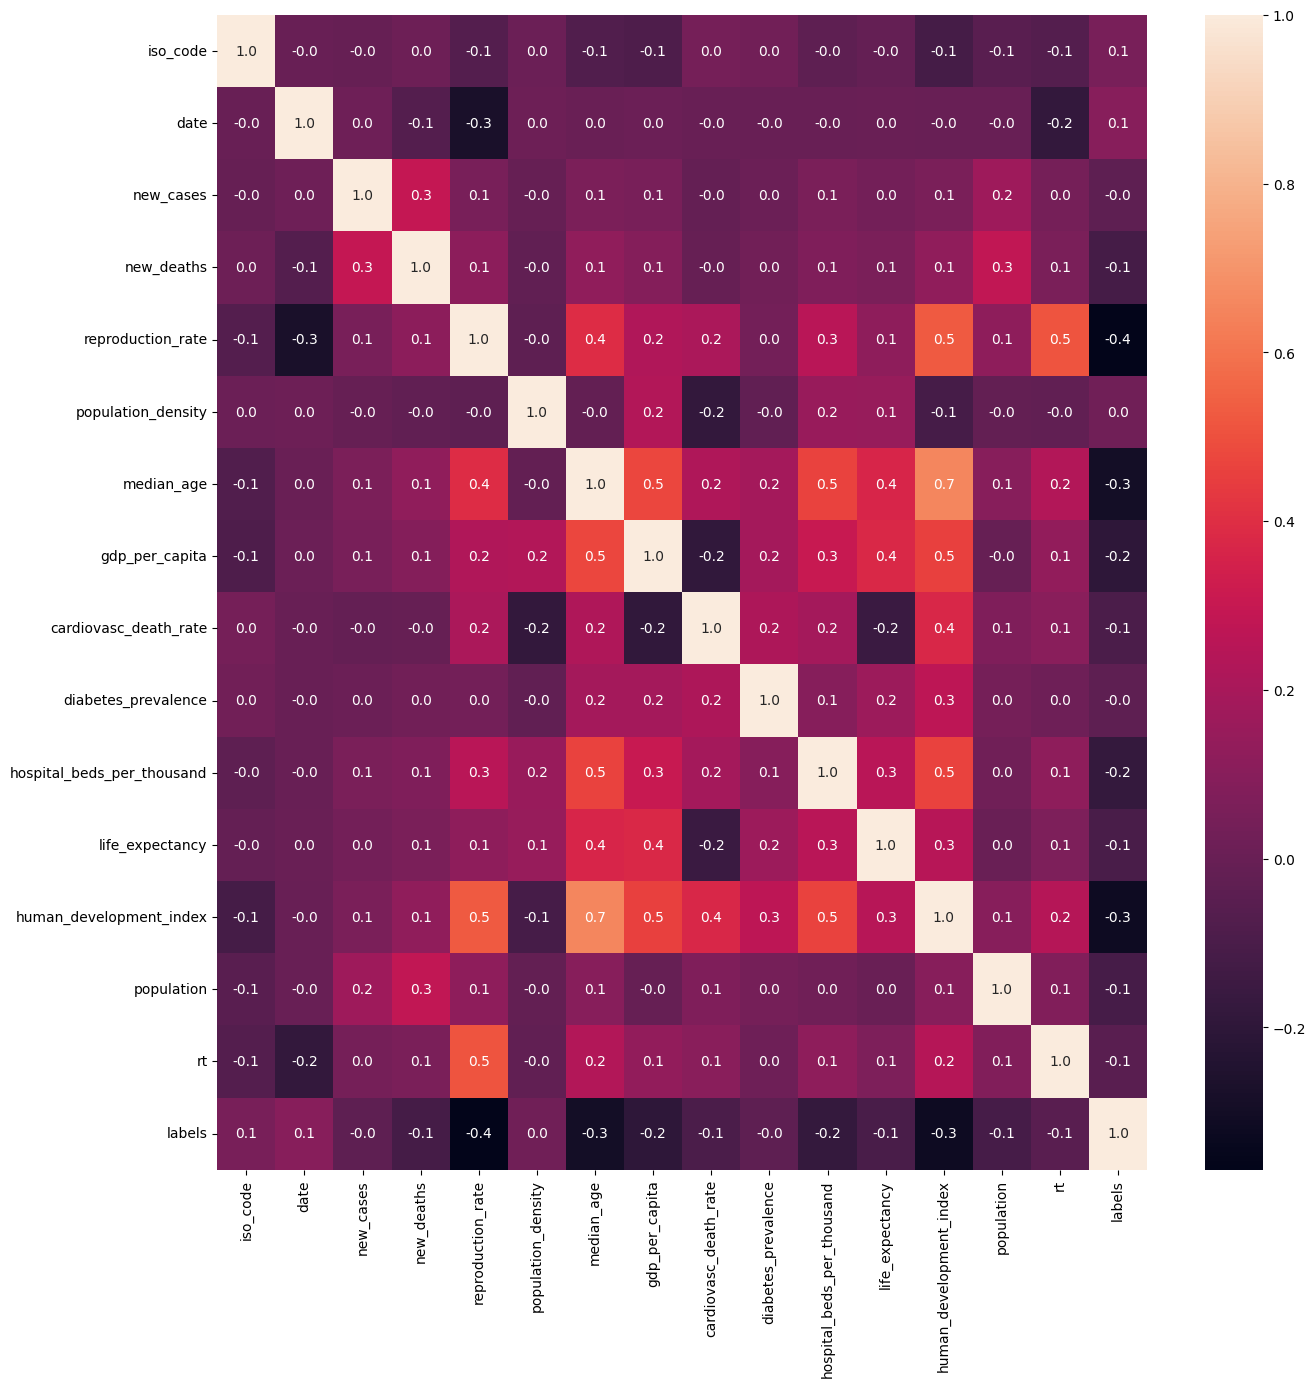

In [11]:

sb.heatmap(kmeans_df.corr(), annot=True, fmt='.1f')

In [12]:
filtered_df = kmeans_df[['date', 'iso_code', 'labels',
                         'reproduction_rate', 'new_deaths', 'median_age']]

In [13]:
filtered_df

,date,iso_code,labels,reproduction_rate,new_deaths,median_age
69,1.583960e+18,1,1,0.0,0,18.6
70,1.584047e+18,1,0,0.0,0,18.6
71,1.584133e+18,1,0,0.0,0,18.6
72,1.584220e+18,1,0,0.0,0,18.6
73,1.584306e+18,1,1,0.0,0,18.6
...,...,...,...,...,...,...
318380,1.682802e+18,235,2,0.0,1,19.6
318381,1.682888e+18,235,2,0.0,0,19.6
318382,1.682975e+18,235,0,0.0,0,19.6
318383,1.683061e+18,235,1,0.0,1,19.6


# Разбиение данных

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x = filtered_df.drop(columns=['labels'])
y = filtered_df[['labels']]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, stratify=y)

# Обучение моделей


In [17]:
from sklearn.metrics import confusion_matrix, classification_report


In [18]:
results = pd.DataFrame(columns=['name', 'score'])
predicts = {}


In [19]:


def get_result(name: str) -> dict:
    result = results[results.name == name].to_numpy()[0]
    return {
        'name': result[0],
        'score': result[1]
    }


In [20]:

def learn_and_score(model, name: str):
    model.fit(x_train, y_train)
    predicted = model.predict(x_test)

    score = round(model.score(x_test, y_test), 4)

    results.loc[len(results)] = {'name': name,
                                 'score': score}
    predicts[name] = predicted

    return score, predicted


In [21]:


def model_report(name: str):
    result = get_result(name)
    predicted = predicts[name]

    print(f'----- {name} -----')
    print('Accuracy score: {}%'.format(result['score'] * 100))
    print(classification_report(y_test, predicted))
    print('Confusion matrix')
    sb.heatmap(confusion_matrix(y_test, predicted), annot=True, fmt='.1f')
    print('----------------------')


In [22]:


def total_report():
    sb.barplot(results, y='name', x='score')


## Случайный лес


Начну с модели случайного леса, так как она может хорошо справляться с несбалансированной выборкой


In [23]:
from sklearn.ensemble import RandomForestClassifier


In [24]:
random_forest = RandomForestClassifier(random_state=12, n_jobs=-2)
RANDOM_FOREST = 'random_forest'

learn_and_score(random_forest, RANDOM_FOREST)


C:\Users\VPR\AppData\Local\Temp\ipykernel_3016\3754592802.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


(0.8459, array([0, 0, 0, ..., 1, 1, 0]))

----- random_forest -----
Accuracy score: 84.59%
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     44178
           1       0.88      0.86      0.87     30742
           2       0.43      0.30      0.35      5394

    accuracy                           0.85     80314
   macro avg       0.72      0.69      0.70     80314
weighted avg       0.84      0.85      0.84     80314

Confusion matrix
----------------------


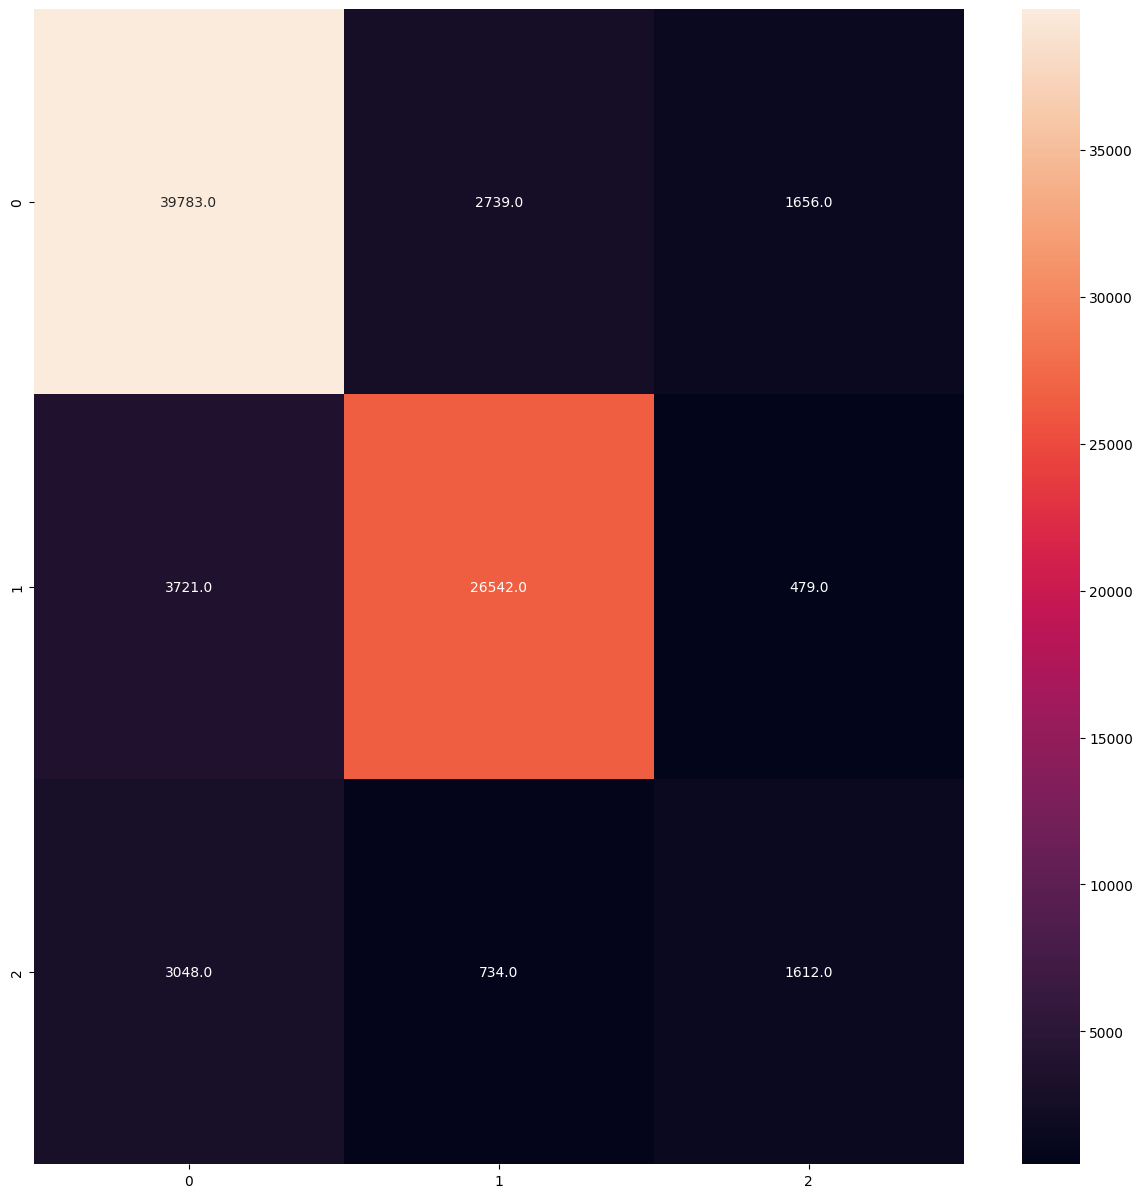

In [25]:
model_report(RANDOM_FOREST)


Очень хорошая точность для начала, даже для некоторых малочисленных классов, барьер чувствительности находится в районе 60-70 единиц, судя по всему


## Дерево решений


Попробую теперь дерево решений, потому что иногда оно показывает себя лучше и быстрее леса


In [26]:
from sklearn.tree import DecisionTreeClassifier


In [27]:
tree = DecisionTreeClassifier(random_state=42)
TREE = 'tree'
learn_and_score(tree, TREE)


(0.8192, array([0, 0, 1, ..., 1, 1, 0]))

----- tree -----
Accuracy score: 81.92%
              precision    recall  f1-score   support

           0       0.86      0.85      0.85     44178
           1       0.85      0.86      0.86     30742
           2       0.34      0.35      0.34      5394

    accuracy                           0.82     80314
   macro avg       0.68      0.69      0.68     80314
weighted avg       0.82      0.82      0.82     80314

Confusion matrix
----------------------


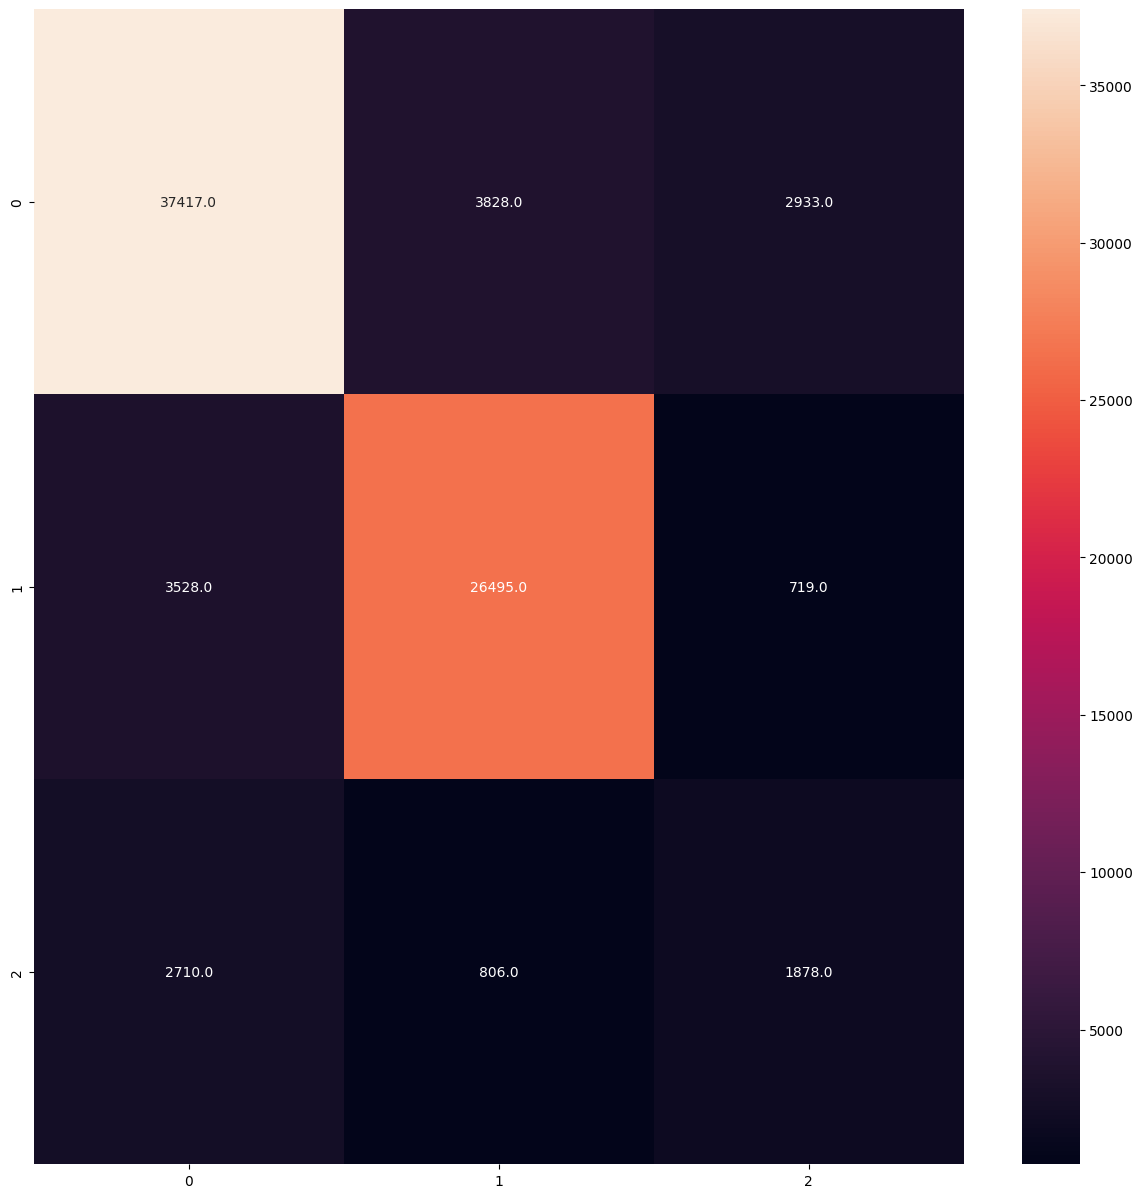

In [28]:
model_report(TREE)


В единоличном виде дерево показало себя хуже леса в среднем и большинстве классов, но в одном результат стал несколько лучше. Возможно, с более мелким дроблением дерево покажет себя лучше


## Соседи


Соседи считает отличным алгоритмом для классификации. Его часто используют при работе с текстом


In [29]:
from sklearn.neighbors import KNeighborsClassifier


In [30]:
neighbors = KNeighborsClassifier(n_jobs=-1)
NEIGHBORS = 'neighbors'
learn_and_score(neighbors, NEIGHBORS)


c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


(0.6459, array([0, 1, 0, ..., 1, 0, 0]))

----- neighbors -----
Accuracy score: 64.59%
              precision    recall  f1-score   support

           0       0.67      0.78      0.72     44178
           1       0.61      0.56      0.58     30742
           2       0.20      0.02      0.04      5394

    accuracy                           0.65     80314
   macro avg       0.49      0.46      0.45     80314
weighted avg       0.62      0.65      0.62     80314

Confusion matrix
----------------------


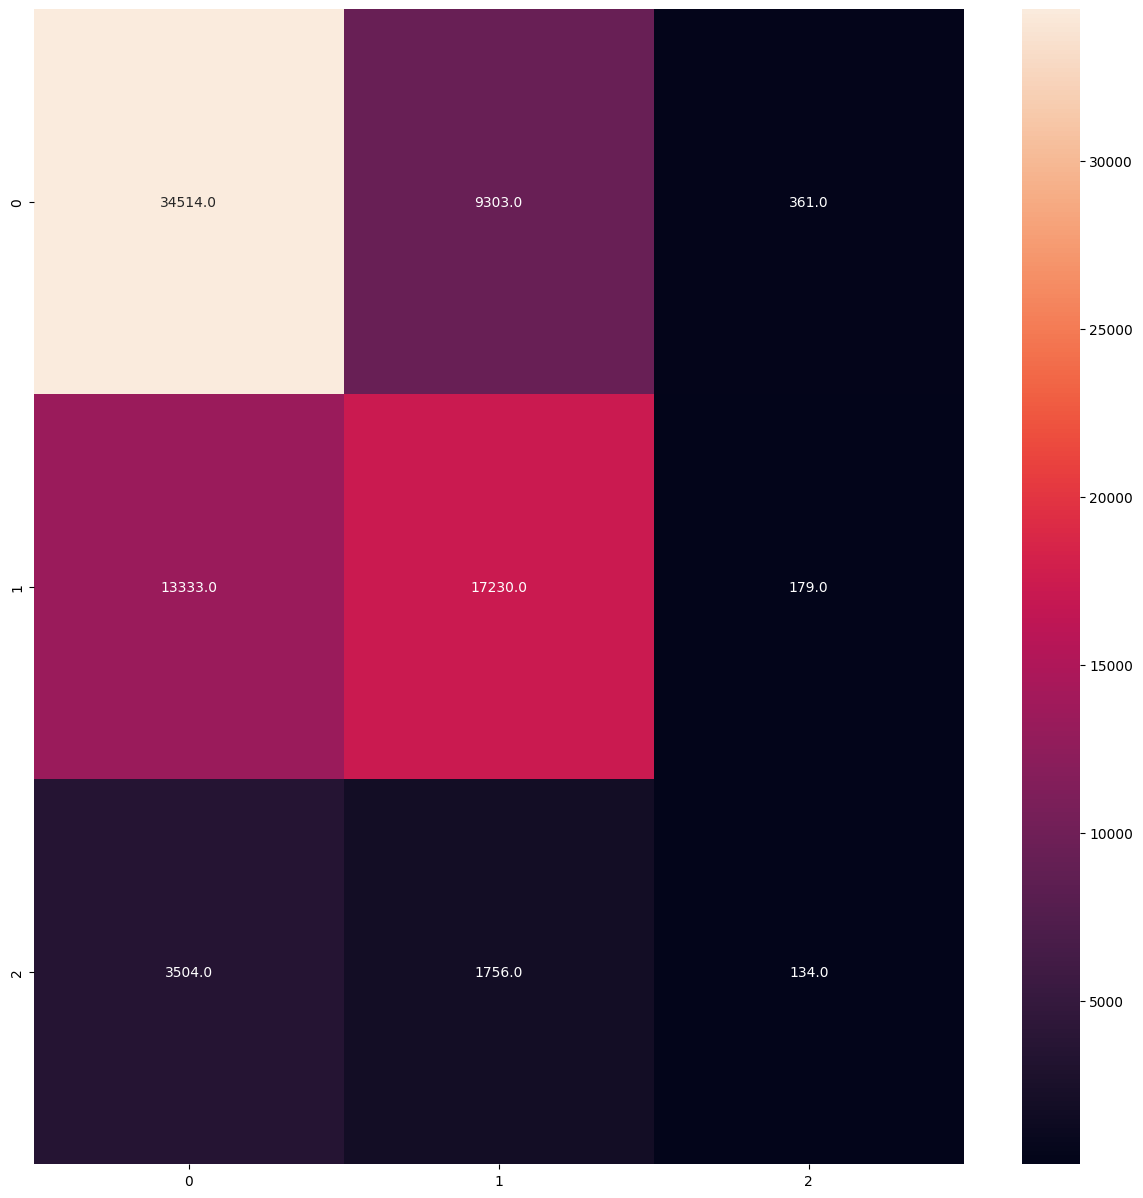

In [31]:
model_report(NEIGHBORS)


Средний результат немного превосходит лес


## Наивный Байес


Тоже популярная модель для классификации и довольно быстро работает. Иногда, при работе с текстом, показывает себя лучше леса


In [32]:
from sklearn.naive_bayes import GaussianNB


In [33]:
bayes = GaussianNB()
BAYES = 'bayes'
learn_and_score(bayes, BAYES)


c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.6082, array([0, 1, 1, ..., 0, 0, 0]))

c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----- bayes -----
Accuracy score: 60.81999999999999%
              precision    recall  f1-score   support

           0       0.61      0.86      0.71     44178
           1       0.61      0.35      0.45     30742
           2       0.00      0.00      0.00      5394

    accuracy                           0.61     80314
   macro avg       0.41      0.40      0.39     80314
weighted avg       0.57      0.61      0.56     80314

Confusion matrix
----------------------


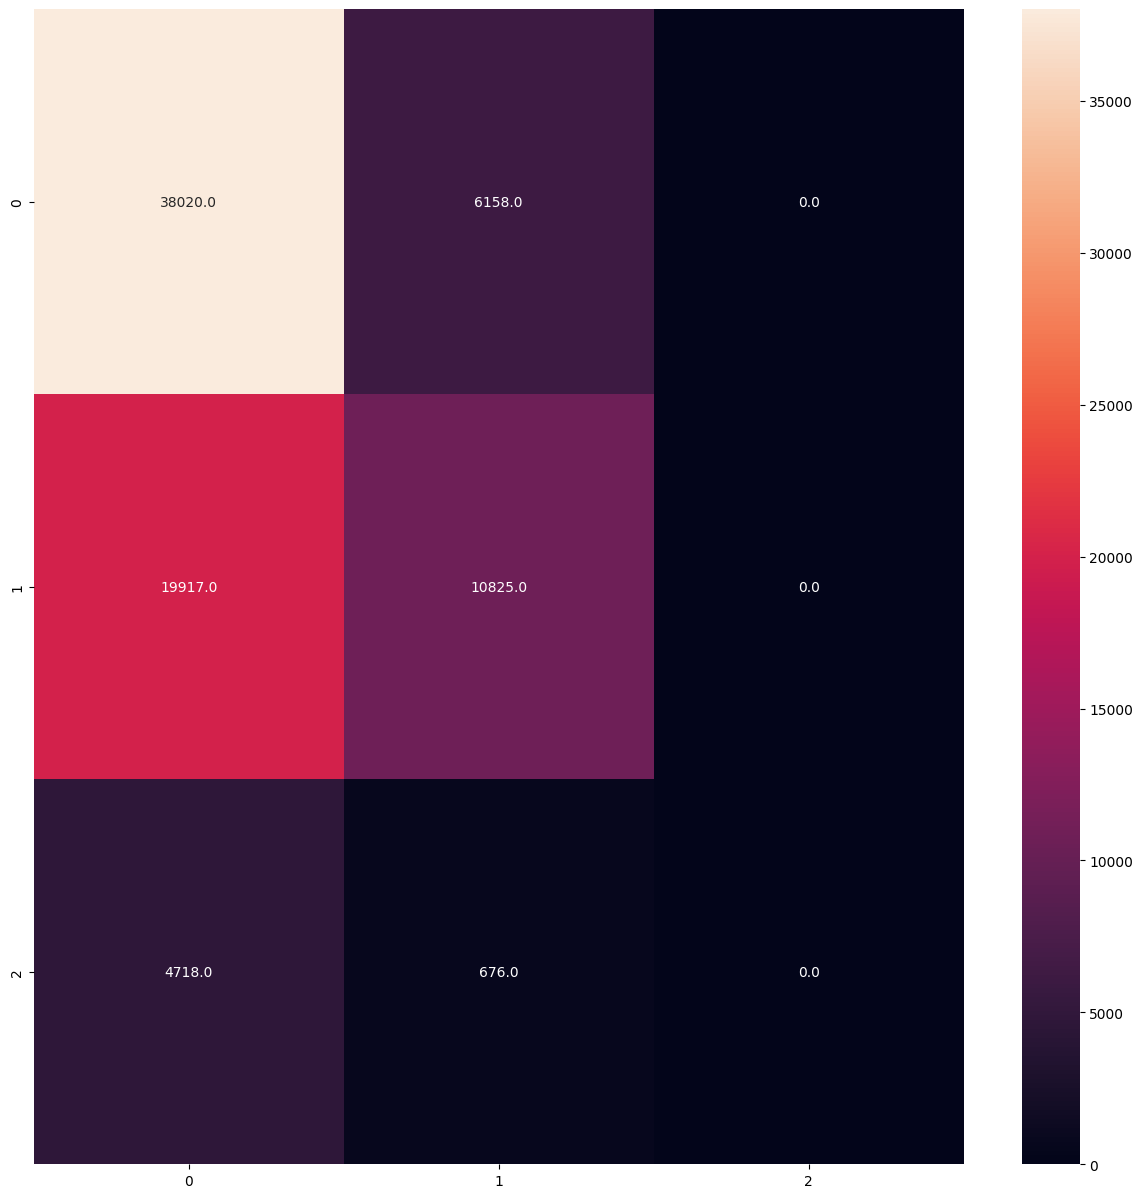

In [34]:
model_report(BAYES)


Алгоритм сработал, на удивление, плохо. Некоторые классы по нулям. Скорее всего сказывается разбиение данных или небольшая выборка по этим классам в целом


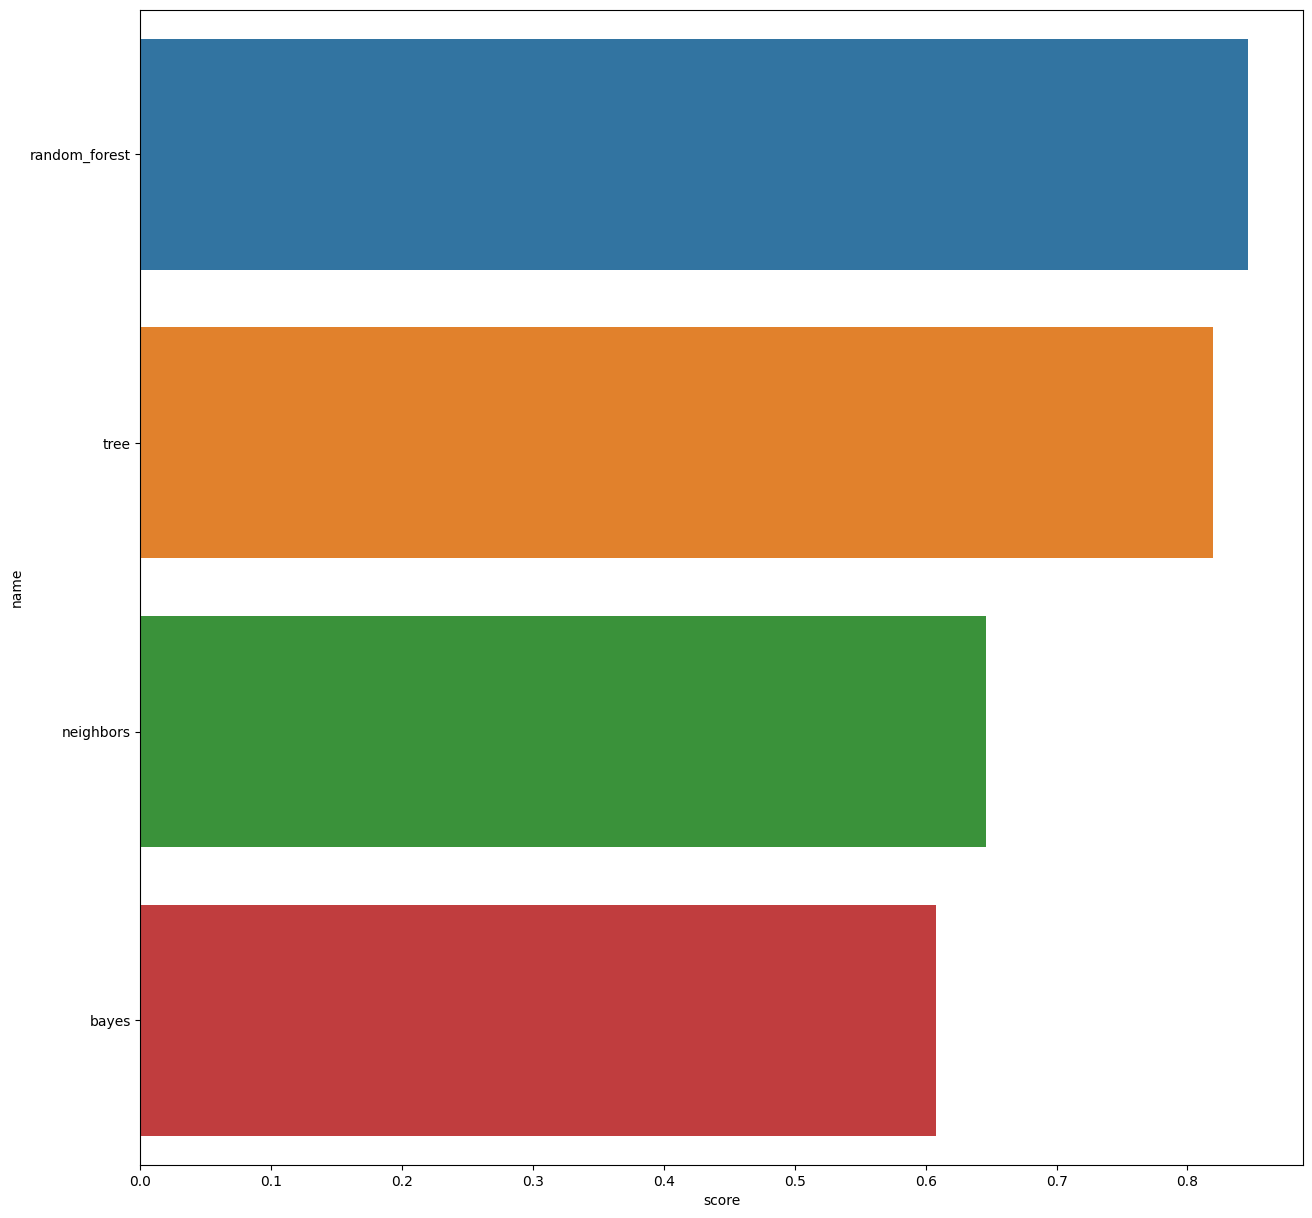

In [35]:
total_report()

Попробую улучшить лес и соседей, потому что лес имеет лучший результат, а соседи другой алгоритм, который тоже неплохо сработал

# Гиперпараметры


In [36]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import math

Некоторые функции для автоматизации подбора параметров и показывания метрик


In [37]:
def random_search(model, params, X_train):
    search = RandomizedSearchCV(
        model, params, random_state=42, n_jobs=-2, return_train_score=True)
    search.fit(X_train, y_train)
    return pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score', ascending=True)

In [38]:
def results_report(results: pd.DataFrame, in_row=3):
    columns = list(
        filter(lambda name: name.startswith('param_'), results.columns))

    row_count = math.ceil(len(columns) / in_row)

    _, axs = mpl.subplots(nrows=row_count, ncols=in_row)

    for index, column in enumerate(columns):
        col = index % in_row
        row = index // in_row
        sb.barplot(results, x=column, y='mean_test_score', ax=axs[row, col])

In [39]:
def grid_search(model, params, X_train):
    search = GridSearchCV(model, params, n_jobs=-2, return_train_score=True)
    search.fit(X_train, y_train)
    return search.best_params_


## Лес


In [40]:
base_forest_params = {
    'random_state': 42,
    'n_jobs': -2
}

In [41]:
search_forest_params = {
    'n_estimators': np.arange(50, 400, 50),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.concatenate([np.arange(5, 16, 2), [None]]),
    'min_samples_leaf': np.arange(1, 10, 2),
    'min_samples_split': np.arange(2, 15, 2),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [42]:
base_forest = RandomForestClassifier(**base_forest_params)
forest_results = random_search(base_forest, search_forest_params, x_train)

c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


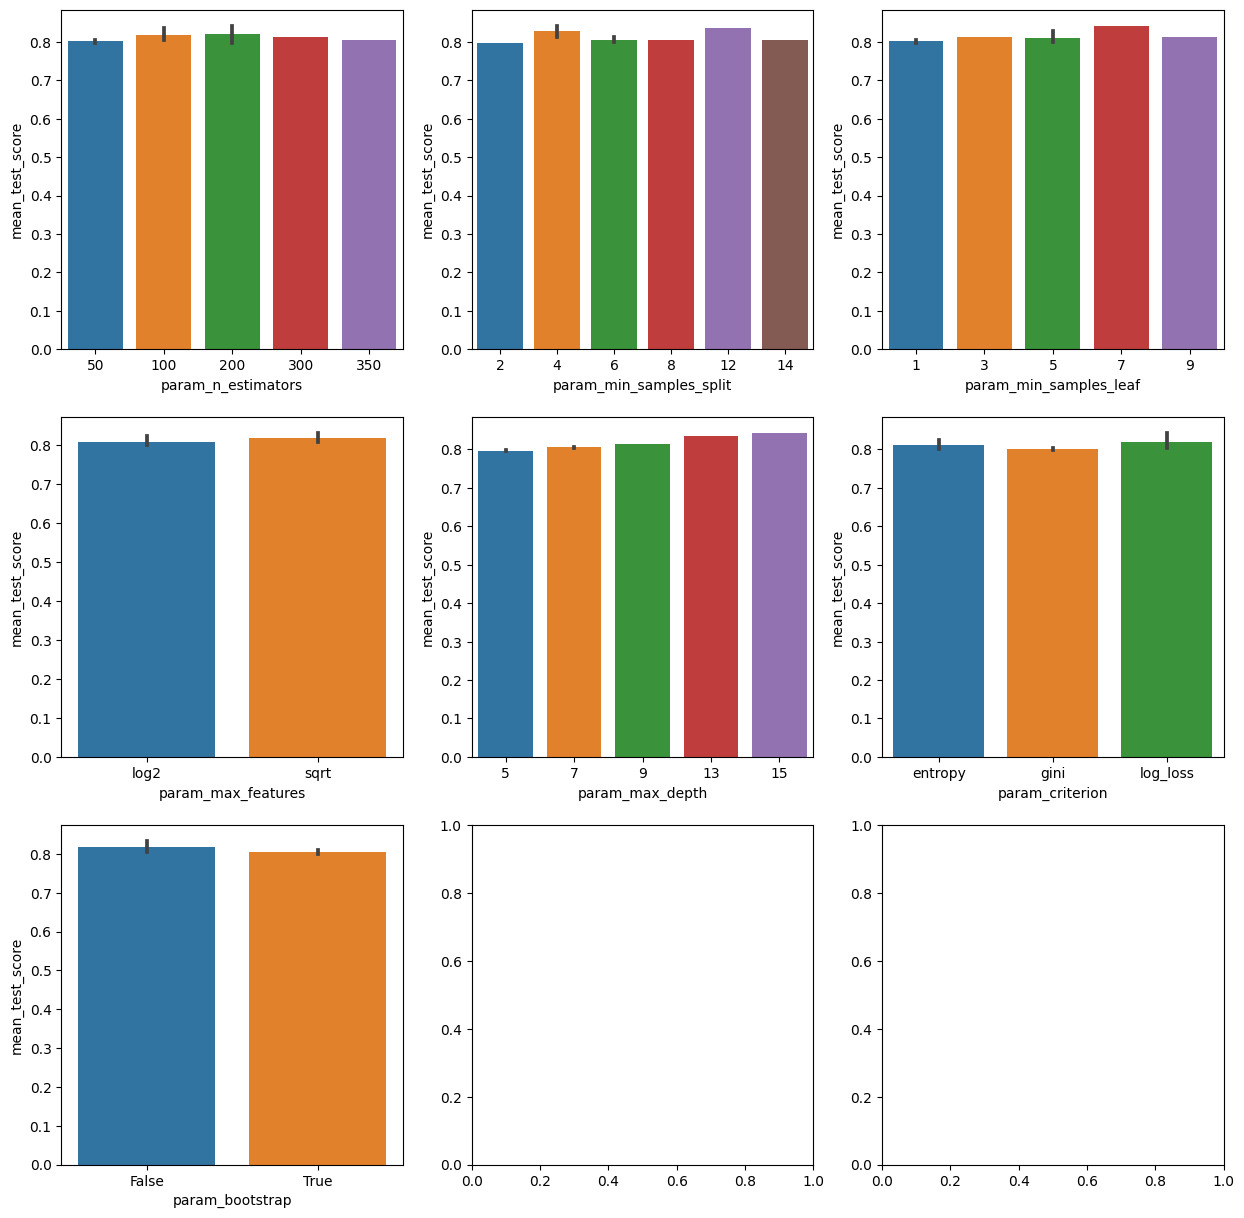

In [43]:
results_report(forest_results)

Точно можно сказать, что:

- criterion - log_loss
- max_features - sqrt
- bootstrap - False
- max_depth - 15
- min_samples_leaf - 7
- min_samples_split - 12

Нужно еще проверить:

- n_estimators - between 150 and 230


In [44]:
prebest_forest_params = {
    'criterion': 'log_loss',
    'max_features': 'sqrt',
    'bootstrap': False,
    'min_samples_split': 12,
    'min_samples_leaf': 7,
    'max_depth': 15,
}

grid_forest_params = {
    'n_estimators': np.arange(150, 230, 10),
}

In [45]:
prebest_forest = RandomForestClassifier(
    **base_forest_params, **prebest_forest_params)
best_forest_params = grid_search(prebest_forest, grid_forest_params, x_train)

c:\Users\VPR\Desktop\big-data\.venv\lib\site-packages\sklearn\model_selection\_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [46]:
best_forest = RandomForestClassifier(**base_forest_params, **prebest_forest_params, **best_forest_params)
BEST_FOREST='best forest'
learn_and_score(base_forest, BEST_FOREST)

C:\Users\VPR\AppData\Local\Temp\ipykernel_3016\3754592802.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


(0.8456, array([0, 0, 0, ..., 1, 1, 0]))

----- best forest -----
Accuracy score: 84.56%
              precision    recall  f1-score   support

           0       0.85      0.90      0.88     44178
           1       0.88      0.86      0.87     30742
           2       0.43      0.30      0.35      5394

    accuracy                           0.85     80314
   macro avg       0.72      0.69      0.70     80314
weighted avg       0.84      0.85      0.84     80314

Confusion matrix
----------------------


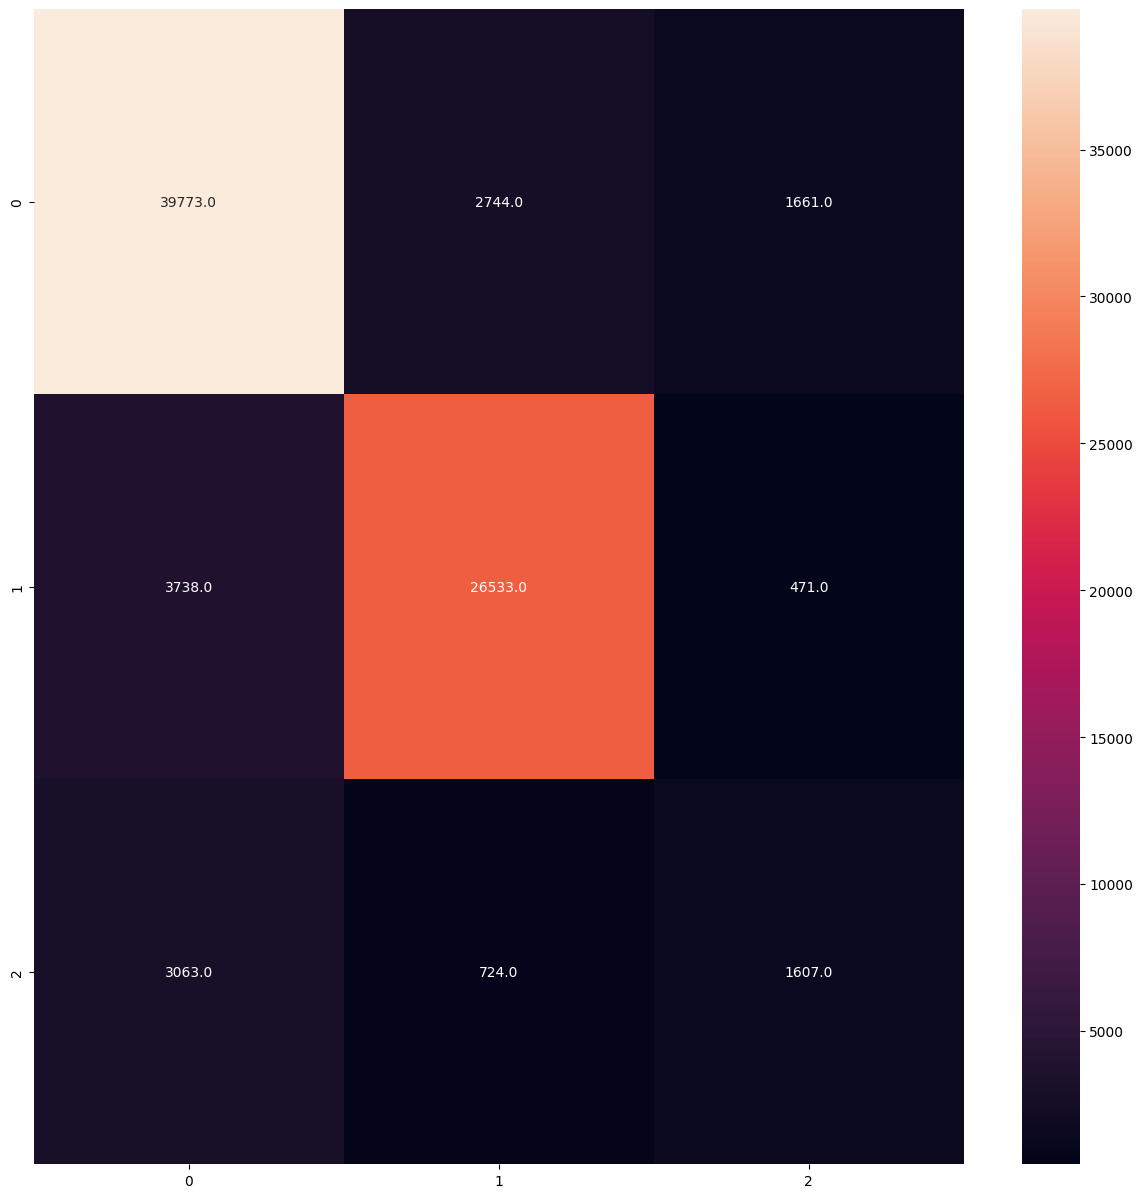

In [47]:
model_report(BEST_FOREST)

Получилось улучшить модель на несколько пп, что довольно хорошо. И точность по кластерам тоже неплохая

## Соседи

In [48]:
base_neighbors_params = {
    'n_jobs': -2
}

In [49]:
search_neighbors_params = {
    'n_neighbors': np.arange(3, 15, 2),
    'weights': ['uniform','distance'],
    'algorithm':['auto','ball_tree','kd_tree','brute'],
    'leaf_size': np.arange(20, 50,5),
    'p': np.arange(1, 10, 2),
}

In [53]:
# base_neighbors = KNeighborsClassifier(**base_neighbors_params)
# neighbors_results = random_search(base_neighbors, search_neighbors_params, x_train)

Слишком долго, оно того не стоит

# Итоги

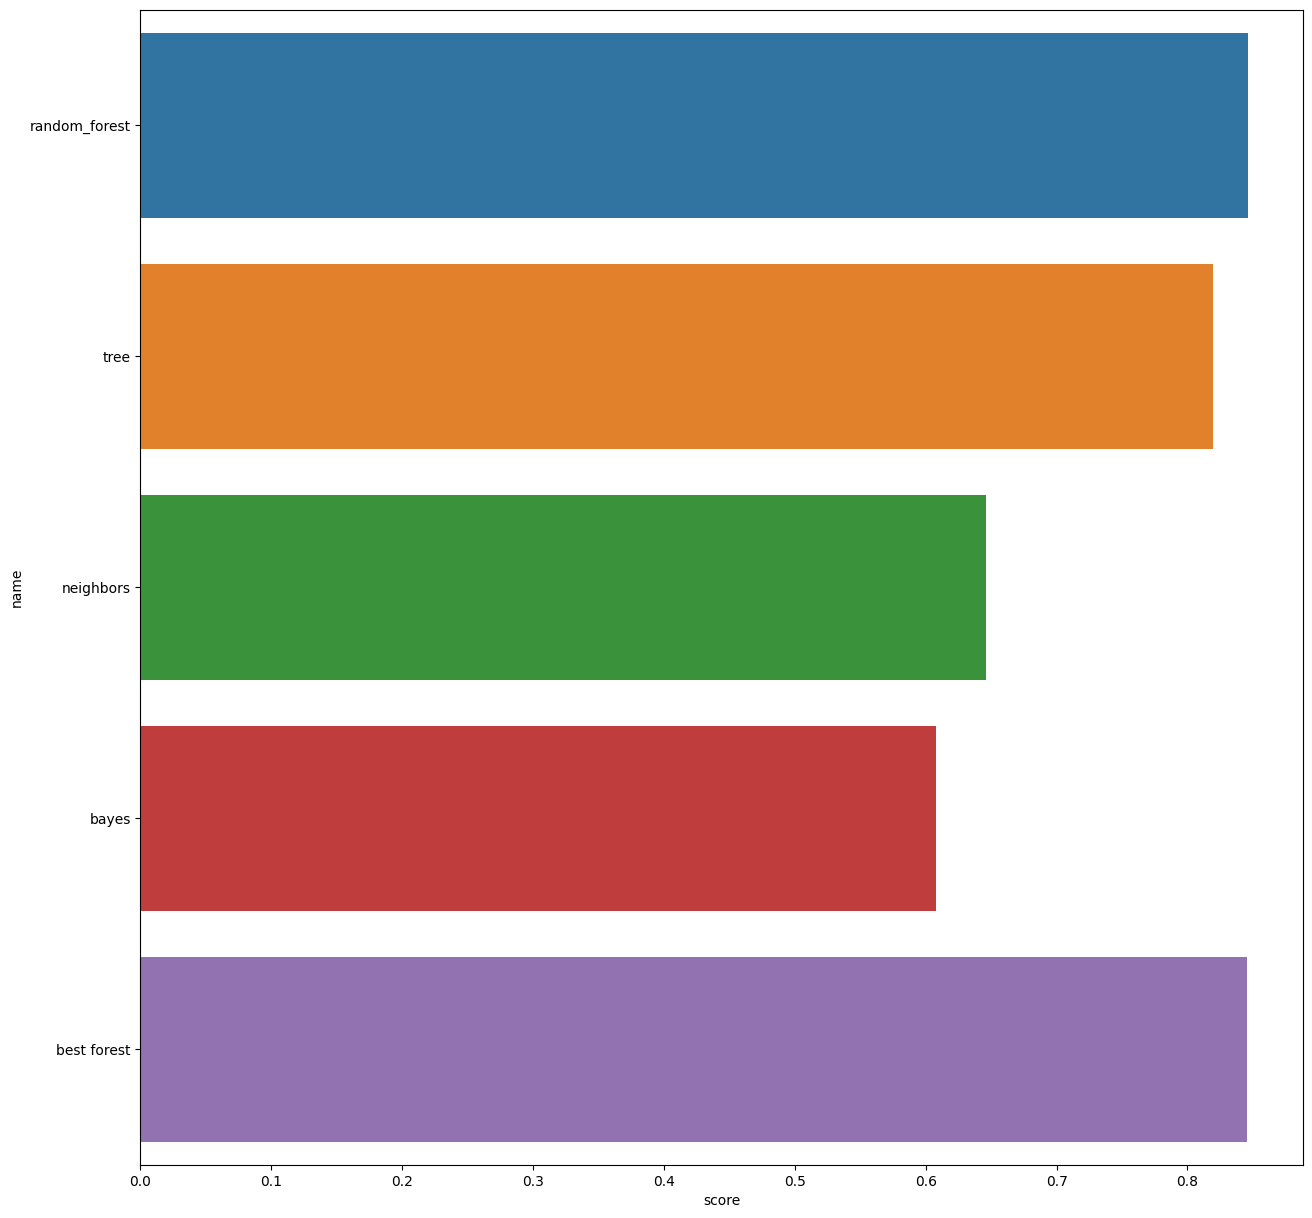

In [51]:
total_report()

Для предсказаний страны лучше всего будет выбрать модель леса с гиперпараметрами, она имеет отличную среднюю точность и хорошо предсказывает безопасные и среднеопасные страны, но плохо подходит для предсказания опасности